In [1]:
import cupy
import cugraph
import cuml
import cudf
import numpy as np
from cuml.neighbors import NearestNeighbors
from cuml import TruncatedSVD, PCA, GaussianRandomProjection, SparseRandomProjection
from cuml import UMAP, TSNE
import time
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import silhouette_score

In [2]:
def compute_embedding(fingerprints_file):
    fp = cupy.load(fingerprints_file, allow_pickle=True)
    fp = fp.astype('float32')
    model = TruncatedSVD(n_components=2)
    model.fit(fp)
    return model.transform(fp)

In [3]:
def compute_clusters_kmeans(embedding):
    model = cuml.KMeans()
    model.fit(embedding)
    return model.predict(embedding)

In [4]:
def compute_neighbors_graph(embedding, n_neighbors=30):
    model = NearestNeighbors(n_neighbors=n_neighbors, output_type="input")
    model.fit(embedding)
    graph = model.kneighbors_graph(X=cupy.asarray(embedding), n_neighbors=n_neighbors, mode='connectivity') 
    return graph

In [5]:
def compute_leiden(graph):
    graph = graph.tocoo()
    edge_list = cudf.DataFrame({'row':graph.row, 'col':graph.col})
    G = cugraph.Graph()
    G.from_cudf_edgelist(edge_list, 'row', 'col')
    parts, modularity_score = cugraph.leiden(G, resolution=1.0)
    leiden_clusters = parts.sort_values('vertex')['partition']
    return leiden_clusters

In [6]:
def compute_umap(embedding):
    model = UMAP(output_type='numpy', n_neighbors=200)
    model.fit(embedding)
    return model.fit_transform(embedding)

In [7]:
def compute_tsne(embedding):
    model = TSNE(output_type='numpy', perplexity=30, n_neighbors=1000)
    return model.fit_transform(embedding)

In [13]:
def batched_silhouette(embedding, clusters):
    rand_idxs = np.array(list(range(0,len(embedding))))
    np.random.shuffle(rand_idxs)
    embedding = cupy.asnumpy(embedding)[rand_idxs]
    clusters = cupy.asnumpy(clusters)[rand_idxs]
    scores = []
    batch_size = 5000
    for i in range(0, len(embedding), batch_size):
        score = silhouette_score(embedding[i:i+batch_size], clusters[i:i+batch_size])
        print(score)
        scores.append(score)
    return np.mean(scores)

In [9]:
def plot_molecules(embedding, clusters):
    ax = plt.axes()
    embedding = cupy.asnumpy(embedding)
    clusters = cupy.asnumpy(clusters)
    ax.scatter(embedding[:,0], embedding[:,1], c=clusters)
    plt.show()

In [10]:
def run_pipeline_graph(fingerprints_file):
    start = time.time()
    embedding = compute_embedding(fingerprints_file)
    print("Computing embedding with TruncatedSVD took " + str(time.time()-start) + " seconds")
    start = time.time()
    graph = compute_neighbors_graph(embedding)
    print("Computing neighbors graph took " + str(time.time()-start) + " seconds")
    start = time.time()
    clusters = compute_leiden(graph)
    print("Computing leiden clusters took " + str(time.time()-start) + " seconds")
    start = time.time()
    manifold_embedding = compute_umap(embedding)
    print("Computing Manifold embedding took " + str(time.time()-start) + " seconds")
    start = time.time()
    plot_molecules(embedding, clusters)
    print("Plotting took " + str(time.time()-start) + " seconds")
    silhouette = batched_silhouette(embedding, clusters)
    print("Average silhouette score: " + str(silhouette))

In [11]:
def run_pipeline_kmeans(fingerprints_file):
    start = time.time()
    embedding = compute_embedding(fingerprints_file)
    print("Computing embedding with TruncatedSVD took " + str(time.time()-start) + " seconds")
    start = time.time()
    clusters = compute_clusters_kmeans(embedding)
    print("Computing KMeans clusters took " + str(time.time()-start) + " seconds")
    start = time.time()
    plot_molecules(embedding, clusters)
    print("Plotting took " + str(time.time()-start) + " seconds")
    silhouette = batched_silhouette(embedding, clusters)
    print("Average silhouette score: " + str(silhouette))

Computing embedding with TruncatedSVD took 1.3186371326446533 seconds
Computing KMeans clusters took 0.2255840301513672 seconds


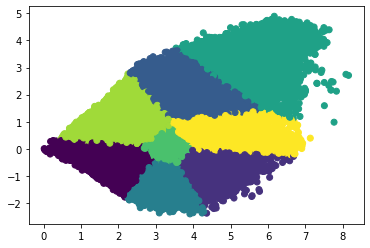

Plotting took 6.725153207778931 seconds
0.3222595
0.32098165
0.31829354
0.32378995
0.32213604
0.32332084
0.3198868
0.31779566
0.32184842
0.322684
0.32602504
0.32157466
0.32657456
0.3175338
0.3181958
0.3224581
0.31928927
0.3253192
0.32156754
0.32174522
0.31998378
0.31827572
0.32647607
0.31867218
0.3237559
0.32337174
0.32168612
0.31583068
0.3206426
0.31596652
0.31866813
0.32263988
0.32615378
0.32232803
0.32490873
0.3159812
0.31967026
0.3277647
0.32420856
0.32433662
0.32297048
0.3217605
0.32509622
0.32016024
0.31978106
0.32250363
0.31991947
0.3235743
0.32023588
0.3305561
0.32205072
0.32059088
0.31886753
0.32253465
0.321513
0.32483804
0.32423827
0.32439628
0.3233754
0.32465592
0.32400373
0.32264876
0.3204102
0.3237188
0.31920955
0.32543686
0.32421517
0.32188514
0.32401675
0.3258507
0.32734698
0.32212573
0.32704127
0.31790566
0.32219702
0.3231056
0.31615233
0.3214093
0.32244903
0.32295597
0.31585565
0.3229595
0.32384703
0.31969061
0.32836205
0.31906998
0.31707528
0.3191542
0.31921363
0.3166

In [15]:
run_pipeline_kmeans("ecfp.pkl")